
Recall the dataset given in Exercise2DataSet, that includes 14 features representing the clinical conditions of 500 ICU patients and the target variable death representing whether the patient died (=1) in the ICU or discharged alive (=0). Using the same dataset, now try Regularized Logistic Regression (both L1 and L2 penalties and different C values), KNN classifier (different numbers of neighbors you believe to be reasonable), random forests (different numbers of trees and different numbers of features to select at each split of your selection) and gradient boosting classifier (different numbers of trees and learning rates of your selection). BE CAREFUL that the best model should be selected using cross validation hence you should never evaluate methods using the test set during the model selection. Also, be very careful that the standardization needs to be carefully done during cross validation not to end up with data snooping (recall the pipe approach discussed in the class). 
Once you decide on the final method and the set of best parameters, refit your model on the standardized training set and evaluate the performance (accuracy) on the standardized test set. Also provide the test confusion matrix, as well as test ROC-AUC score of the best model.  


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [2]:
# Read data
df = pd.read_csv("Exercise2DataSet.csv")

# see of the data
df.head()

,age,LOS,previous_LOS,previous_ICU_stays,cvc_status,SIRS_48_hour,MV_24_hour,Initial_SOFA,Discharge_SOFA,Max_SOFA,AdmitApache,DischargeApache,sex,Type,death
0,86,160.983333,1.800000,0,0,0,0,6,3,6,66,57,F,Surgical,0
1,61,103.533333,11.433333,0,1,1,0,7,4,7,80,73,F,Surgical,0
2,22,572.383333,14.450000,0,1,1,0,10,4,12,90,74,F,Surgical,0
3,58,51.200000,0.000000,0,1,1,1,7,3,7,78,64,M,Medical,0
4,18,35.116667,0.000000,0,0,1,1,7,2,7,73,49,M,Medical,0


In [46]:
# Create of the independed and depended variables
X = df.drop("death", axis = 1)
y = df["death"]

In [47]:
# Dropping sex and Type columns.
X.drop(X[["sex", "Type"]], axis = 1, inplace = True)

In [5]:
# Convert categorical variables to dummy variables
dummies = pd.get_dummies(df[["sex", "Type"]]).astype("int")

# Drop specific dummy variables
dummies.drop(dummies[["sex_F", "Type_Medical"]], axis = 1, inplace = True)

# Check for any null values
dummies.isnull().sum()

sex_M            0
Type_Surgical    0
dtype: int64

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [45]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
X_trainStandard = scaler.transform(X_train)

# Transform the test data using the same scaler fitted on the training data
X_testStandard = scaler.transform(X_test)

In [43]:
# Create a pipeline
pipe = Pipeline([('scaler', preprocessing.StandardScaler()),('model',LogisticRegression())])

# Create space of candidate learning algorithms and their hyperparameters
grid_search = [{"model": [LogisticRegression(solver = "liblinear")],
               "model__max_iter": [50,100,200,300,400,500,600,700,800,900,1000],
               "model__penalty": ["l1", "l2"],
               "model__C": [0.001,0.01,0.1,1,10,100,1000,10000]},
               {"model": [KNeighborsClassifier()],
               "model__n_neighbors": np.arange(2,12)}]

# Create grid search
grid = GridSearchCV(pipe, grid_search, verbose = 2, cv = 10, scoring='accuracy', n_jobs = -1 )

# Fitting grid search
best_model = grid.fit(X_train, y_train)

# View best model
print("best model and parameters:", best_model.best_estimator_.get_params()['model'])


Fitting 10 folds for each of 186 candidates, totalling 1860 fits
best model and parameters: LogisticRegression(C=0.1, max_iter=50, solver='liblinear')


In [44]:
# Create the final logistic regression model with the best parameters found
last_model = LogisticRegression(C = 0.1, max_iter = 50, solver = "liblinear")

# Predict the labels for the standardized test data
last_model.fit(X_trainStandard, y_train)

# Predict the labels for the standardized test data
ypred = last_model.predict(X_testStandard)

# Print the accuracy score of the predictions
print("Best Model Score:", accuracy_score(y_test, ypred))

Best Model Score: 0.91


In [64]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, ypred)

# Display the confusion matrix
confusion

array([[78,  4],
       [ 5, 13]], dtype=int64)

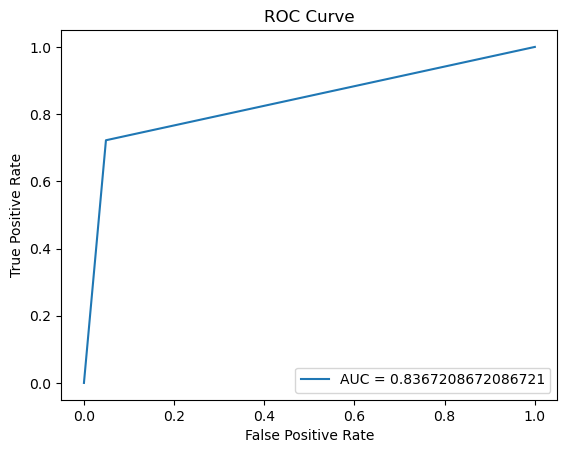

In [63]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, ypred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = ' + str(roc_auc_score(y_test, ypred)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

